In [1]:
import sys
import os, glob
import csv 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from datetime import datetime, date, timedelta
import pandas as pd
import math

In [2]:
#readin soil moisture
start = datetime(2002,1,1,0,0,30); end=datetime(2018,12,31,23,59,59)
trng_hh = pd.date_range(start, end, freq='30min') #'30min','H'

# # Readin FLUXnet Soilm
# in_dir='/Users/linniahawkins/Documents/SPA/SPA-Me2/obs_data/'   
# filename = os.path.join(in_dir+'US-Me2_HH_200201010030_201901010000_Met.csv')
# df = pd.read_csv(filename,header=0,index_col=0, parse_dates=True, squeeze=True)
df = pd.read_csv('US-Me2_HH_200201010030_201901010000_Met.csv')
df.index = trng_hh
df_daily = df.resample('D').mean()

In [3]:
def RetCurv_VGM(psand,psilt,pclay,t):
    #Soil texture constants for sand, silt, and clay
    #Alpha
    sand_a = 0.0016
    silt_a = 0.0034
    clay_a = 0.0099
    #Theta_r (residual moisture contnet)
    sand_tr = 0.061
    silt_tr = 0.083
    clay_tr = 0.107
    #Theta_s (satrated moisture content)
    sand_ts = 0.381
    silt_ts = 0.427
    clay_ts = 0.429
    #n (some are ranges... value is equal to middle value)
    sand_n = (1.29+1.66)/2 #ranges from 1.29 to 1.66
    silt_n = (1.35+1.79)/2 #ranges from 1.35 to 1.79
    clay_n = 1.23
    
    #convert percent soil texture to decimals
    p_sand = psand/100
    p_silt = psilt/100
    p_clay = pclay/100
    
    #genertate paremeters required for VGM
    a = sand_a*p_sand+silt_a*p_silt+clay_a*p_clay
    tr = sand_tr*p_sand+silt_tr*p_silt+clay_tr*p_clay
    ts = sand_ts*p_sand+silt_ts*p_silt+clay_ts*p_clay
    n = sand_n*p_sand+silt_n*p_silt+clay_n*p_clay
    m = 1-(1/n)
    
    #create array representing water content (t) and apply to solve for water potential (h)
    S = (t-tr)/(ts-tr)
    swp_VGM = (((S**(-1/m)-1)**(1/n))/a)/1000000  #devisded by 1000 to make both in units of MPa (assuming that it is orinally in units of Pa****)  
    return swp_VGM

In [4]:
def RetCurv_SR(p_sand,p_clay,swc):
    #def t(p):
    # variable values for the saxton/rawl eq.
    a = -4.396
    b = -0.0715
    c = -4.880*(10**-4)
    d = -4.285*(10**-5)
    e = -3.140
    f = -2.22*(10**-3)
    g = -3.484*(10**-5)
#     #Equations to find A and B in the equation
    A = 100*math.exp(a+b*p_clay+c*(p_sand**2)+d*(p_sand**2)*(p_clay))
    B = e+f*(p_clay**2)+g*(p_sand**2)*(p_clay)  #question about this equation, include the g*(p_sand**2) factor? in paper but not example provided or in paper
    P = (A*(swc**B))/1000
    return P

In [5]:
#Given:  Soils at the site are 69%/24%/7% sand/silt/clay at 0–0.2 m depth and 66%/27%/7% at 0.2–0.5 m depth, and 54%/ 35%/11% at 0.5–1.0 m depth
#66%/27%/7% at 0.2–0.5 m depth
ME2_sand_30 = 66
ME2_silt_30 = 27
ME2_clay_30 = 7

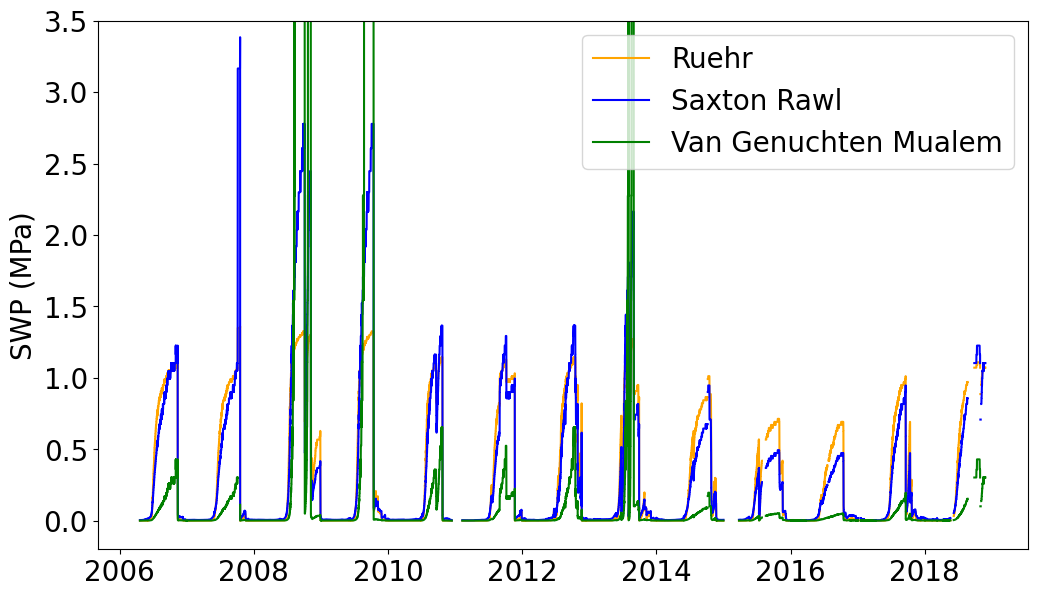

In [6]:
# calculate soil water potential

#original code
# a = -0.4; b = 1.6 ; c = 0.096 ; d = 0.0184
# swc_30 = df['SWC_30cm']/100
# swp_30_R = a - b/(1+np.exp((swc_30-c)/d))
# swp_30_R = -1*swp_30_R

#removes the intercept that was given for the model, produces the Ruehr model
b = 1.6 ; c = 0.096 ; d = 0.0184
swc_30 = df['SWC_30cm']/100
swp_30_R = -b/(1+np.exp((swc_30-c)/d))
swp_30_R = -1*swp_30_R

#
swp_30_SR = RetCurv_SR(ME2_sand_30,ME2_clay_30,swc_30)

#df = df[df['SWC_30cm']>7]
# df['SWC_30cm'].values[df['SWC_30cm'].values < 7.5] = 7.45 #depends of desired residual water content
swc_30_filtered = df['SWC_30cm']/100
swp_30_VGM = RetCurv_VGM(ME2_sand_30,ME2_silt_30,ME2_clay_30,swc_30_filtered) #,swc_min,swc_max)


plt.figure(num=None, figsize=(12, 7), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 20})
plt.plot(swp_30_R,color='orange',label='Ruehr')
plt.plot(swp_30_SR,color='blue',label='Saxton Rawl')
plt.plot(swp_30_VGM,color='green',label='Van Genuchten Mualem')
plt.ylim([-.2, 3.5])
plt.ylabel('SWP (MPa)')
plt.legend()

In [7]:
def RetCurv_VGM_2(psand,psilt,pclay):
    #Soil texture constants for sand, silt, and clay
    #Alpha
    sand_a = 0.0016
    silt_a = 0.0034
    clay_a = 0.0099
    #Theta_r (residual moisture contnet)
    sand_tr = 0.061
    silt_tr = 0.083
    clay_tr = 0.107
    #Theta_s (satrated moisture content)
    sand_ts = 0.381
    silt_ts = 0.427
    clay_ts = 0.429
    #n (some are ranges... value is equal to middle value)
    sand_n = (1.29+1.66)/2 #ranges from 1.29 to 1.66
    silt_n = (1.35+1.79)/2 #ranges from 1.35 to 1.79
    clay_n = 1.23
    
    #convert percent soil texture to decimals
    p_sand = psand/100
    p_silt = psilt/100
    p_clay = pclay/100
    
    #genertate paremeters required for VGM
    a = sand_a*p_sand+silt_a*p_silt+clay_a*p_clay
    tr = sand_tr*p_sand+silt_tr*p_silt+clay_tr*p_clay
    ts = sand_ts*p_sand+silt_ts*p_silt+clay_ts*p_clay
    n = sand_n*p_sand+silt_n*p_silt+clay_n*p_clay
    m = 1-(1/n)
    
    #create array representing water content (t) and apply to solve for water potential (h)
    t = np.linspace(tr, ts, num=50)
    S = (t-tr)/(ts-tr)
    h = (((S**(-1/m)-1)**(1/n))/a)/1000000  #devisded by 1000 to make both in units of MPa (assuming that it is orinally in units of Pa****)
    
    return (t,h)

In [8]:
def RetCurv_SR_2(p_sand,p_clay):
    def t(p):
    # variable values for the saxton/rawl eq.
        a = -4.396
        b = -0.0715
        c = -4.880*(10**-4)
        d = -4.285*(10**-5)
        e = -3.140
        f = -2.22*(10**-3)
        g = -3.484*(10**-5)
        h = 0.332
        j = -7.251*(10**-4)
        k = 0.1276
        m = -0.108
        n = 0.341
    #Equations to find A and B in the equation as well as water contnet at 10 kPa and saturation, as well as the water potential of air entry
        A = 100*math.exp(a+b*p_clay+c*(p_sand**2)+d*(p_sand**2)*(p_clay))
        B = e+f*(p_clay**2)+g*(p_sand**2)*(p_clay)                         #question about this equation, include the g*(p_sand**2) factor? in paper but not example provided or in paper
        t_s = h+j*(p_sand)+k*(np.log10(p_clay))                            #Theta at saturation
        t_10 = math.exp((2.302-np.log(A))/B)                               #Theta at 1o kPa
        P_e = 100*(m+n*(t_s))
    #Conditional statments for different water potentials ranging from 0 to 1500 kPa (I solved for theta for simplicity)
        if p > 10:
            return (p/A)**(1/B)
        elif P_e < p < 10:
            return ((10-p)*(t_s-t_10)/(10-P_e))+t_10
        elif p < P_e:
            return t_s
    return t                   #returns the theta value

#Create array with values repesenative of water potetnial
P = np.linspace(0,1500,1500)

#Convert water potential to MPa from kPa
P_MPa = P/1000

/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in power


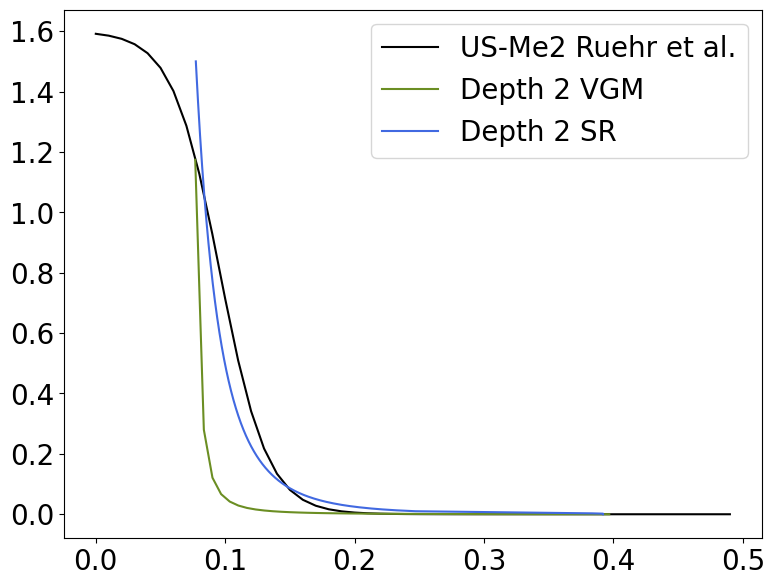

In [9]:
# plot soil water retention curve
SWC = np.arange(0,0.5,0.01)

b = 1.6 ; c = 0.096 ; d = 0.0184
swp1 = []
for i in range(len(SWC)):
    temp = -b/(1+np.exp((SWC[i]-c)/d))
    swp1.append(-temp)

ME2_sand_B = 66
ME2_silt_B = 27
ME2_clay_B = 7

t_M_B_VG,h_M_B = RetCurv_VGM_2(ME2_sand_B,ME2_silt_B,ME2_clay_B)

t2M = RetCurv_SR_2(ME2_sand_B,ME2_clay_B)
t_M_B_SR = [t2M(p) for p in P]

plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
plt.plot(SWC,swp1,label='US-Me2 Ruehr et al.',color='k')
plt.plot(t_M_B_VG, h_M_B, color = 'olivedrab', label = 'Depth 2 VGM')
plt.plot(t_M_B_SR, P_MPa, color = 'royalblue', label = 'Depth 2 SR')
plt.legend()
plt.show()